# scRNAseq mouse primary motorcortex dataset

This notebook is used to tokenize the scRNAseq primary motorcortex dataset and generate dataset statistics for figures in nicheformer. 

## Imports and definitions

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import math
import numba
from scipy.sparse import issparse
from sklearn.utils import sparsefuncs
from pyensembl import EnsemblRelease

import pyarrow.parquet as pq
import pyarrow
from os.path import join
from tqdm import tqdm

In [2]:
modality_dict = {
    'dissociated': 3,
    'spatial': 4,}

specie_dict = {
    'human': 5,
    'Homo sapiens': 5,
    'Mus musculus': 6,
    'mouse': 6,}

technology_dict = {
    "merfish": 7,
    "MERFISH": 7,
    "cosmx": 8,
    "visium": 9,
    "10x 5' v2": 10,
    "10x 3' v3": 11,
    "10x 3' v2": 12,
    "10x 5' v1": 13,
    "10x 3' v1": 14,
    "10x 3' transcription profiling": 15, 
    "10x transcription profiling": 15,
    "10x 5' transcription profiling": 16,
    "CITE-seq": 17, 
    "Smart-seq v4": 18,
}

author_cell_type_dict = {
    'Astro-Epen': 0, 
    'CB GABA': 1, 
    'CB Glut': 2, 
    'CGE GABA': 3, 
    'CNU GABA': 4,
    'CNU-HYa GABA': 5, 
    'CNU-HYa Glut': 6, 
    'HY GABA': 7, 
    'HY Glut': 8,
    'HY Gnrh1 Glut': 9, 
    'HY MM Glut': 10,
    'IT-ET Glut': 11, 
    'Immune': 12, 
    'LQ': 13,
    'LSX GABA': 14, 
    'MB Dopa': 15, 
    'MB GABA': 16, 
    'MB Glut': 17, 
    'MB-HB Sero': 18,
    'MGE GABA': 19, 
    'MH-LH Glut': 20, 
    'MOB-CR Glut': 21, 
    'MOB-DG-IMN': 22, 
    'MY GABA': 23,
    'MY Glut': 24, 
    'NP-CT-L6b Glut': 25, 
    'OEG': 26, 
    'Oligo': 27, 
    'P GABA': 28, 
    'P Glut': 29,
    'Pineal Glut': 30, 
    'TH Glut': 31, 
    'Vascular': 32
}

niche_label_dict = {
    'CBX-MOB-other neuronal': 0, 
    'Immune': 1, 
    'LQ': 2, 
    'Neuroglial': 3,
    'PAL-sAMY-TH-HY-MB-HB neuronal': 4, 
    'Pallium glutamatergic': 5,
    'Subpallium GABAergic': 6, 
    'Vascular': 7
}

region_label_dict = {
    'CB': 0, 
    'CTXsp': 1, 
    'HB': 2, 
    'HIP': 3, 
    'HY': 4, 
    'Isocortex': 5, 
    'LSX': 6, 
    'MB': 7, 
    'OLF': 8,
    'PAL': 9, 
    'RHP': 10, 
    'STRd': 11, 
    'STRv': 12, 
    'TH': 13, 
    'sAMY': 14, 
    'ventricle': 15,
    'white_matter': 16
}

## Paths

In [2]:
BASE_PATH = '../../data/model_means'
DATA_PATH = '' # specify path to raw nicheformer-data object for the cosmy human lung data
OUT_PATH = '' # specify saving  path

## Tokenization functions

In [4]:
def sf_normalize(X):
    X = X.copy()
    counts = np.array(X.sum(axis=1))
    # avoid zero devision error
    counts += counts == 0.
    # normalize to 10000. counts
    scaling_factor = 10000. / counts

    if issparse(X):
        sparsefuncs.inplace_row_scale(X, scaling_factor)
    else:
        np.multiply(X, scaling_factor.reshape((-1, 1)), out=X)

    return X

@numba.jit(nopython=True, nogil=True)
def _sub_tokenize_data(x: np.array, max_seq_len: int = -1, aux_tokens: int = 30):
    scores_final = np.empty((x.shape[0], max_seq_len if max_seq_len > 0 else x.shape[1]))
    for i, cell in enumerate(x):
        nonzero_mask = np.nonzero(cell)[0]    
        sorted_indices = nonzero_mask[np.argsort(-cell[nonzero_mask])][:max_seq_len] 
        sorted_indices = sorted_indices + aux_tokens # we reserve some tokens for padding etc (just in case)
        if max_seq_len:
            scores = np.zeros(max_seq_len, dtype=np.int32)
        else:
            scores = np.zeros_like(cell, dtype=np.int32)
        scores[:len(sorted_indices)] = sorted_indices.astype(np.int32)
        
        scores_final[i, :] = scores
        
    return scores_final


def tokenize_data(x: np.array, median_counts_per_gene: np.array, max_seq_len: int = None):
    """Tokenize the input gene vector to a vector of 32-bit integers."""

    x = np.nan_to_num(x) # is NaN values, fill with 0s
    x = sf_normalize(x)
    median_counts_per_gene += median_counts_per_gene == 0
    out = x / median_counts_per_gene.reshape((1, -1))

    scores_final = _sub_tokenize_data(out, 4096, 30)

    return scores_final.astype('i4')

# scRNAseq data

In [3]:
dissociated = sc.read_h5ad(f"{DATA_PATH}/mouse_brain_haviv.h5ad")

In [5]:
abundances = pd.DataFrame(pd.value_counts(dissociated.obs.original_author_cell_type)).reset_index().sort_values(by='index')

In [7]:
order_logic = {
    # Astro
    'Astro':'A', 
    # oligo
    "Oligo": 'B0', "OPC": 'B1',
     "Endo": 'C0', "VLMC": 'C1',
     'Microglia': 'D',
    # CGE neurons
   
    # IT-ET Glut
     'L23_IT': 'E0', 'L5_ET': 'E1', 'L5_IT': 'E2', 'L6_IT': 'E3', 'L6_IT_Car3': 'E4', 
    # Immune
    
    # MB Glut	
    "L56_NP": 'F2', "L6_CT": 'F1', "L6b": 'F0',
      
    # MGE 
    "Pvalb": 'G0', "Sst": 'G1',
    #Oligo
    'Lamp5':'H1', 'Sncg':'H0', 'Vip': 'H2', 
   
}
abundances['sort'] = [order_logic[x] for x in list(abundances['index'])]
abundances = abundances.sort_values(by='sort')

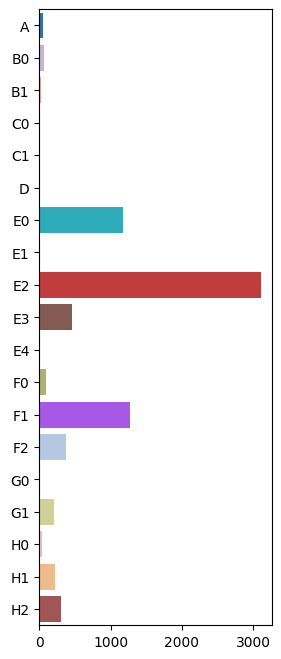

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(3,8))
sns.barplot(
    y=list(abundances['sort']), x=list(abundances['original_author_cell_type']), 
    ax=ax,
    palette=[
        '#1F77B4', '#C5B0D5', '#FF9896', 
        '#FF7F0E', '#9EDAE5', '#98DF8A', 
        '#17BECF', '#279E68', '#D62728', 
        
        '#8C564B', '#E377C2',
        '#B5BD61', '#AA40FC', '#AEC7E8', '#C49C94', '#DBDB8D', '#F7B6D2', '#FFBB78', '#AD494A'
    ],
    #order=abundances['sort']
)
ax.grid(False)

## Loading model with right gene ordering

In [8]:
model = sc.read_h5ad(
    f"{BASE_PATH}/model.h5ad"
)

## Concatenation
Next we concatenate the `model` and the `dissociated` object to ensure they are in the same order. This ensures we have the same gene ordering in the object.

In [25]:
adata = ad.concat([model, dissociated], join='outer', axis=0)
# dropping the first observation 
adata_output = adata[1:].copy()
# for memory efficiency 
del adata

In [27]:
adata_output = adata_output[:, model.var.index]

In [16]:
kept = []

for i in range(len(adata_output.var.index)):
    if adata_output.var.index[i] in dissociated.var.index:
        kept.append(i)

print(len(kept))

483


In [17]:
common_genes = adata_output.var.iloc[kept].index

In [40]:
adata_output.obs = adata_output.obs[
    ['assay', 'organism', 'nicheformer_split']
]
adata_output.obs['modality'] = 'dissociated'
adata_output.obs['nicheformer_split'] = 'train'
adata_output.obs['specie'] = adata_output.obs.organism

/home/icb/anna.schaar/miniconda3/envs/nf-data/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
del adata_output.layers

In [12]:
adata_output.obs.replace({'specie': specie_dict}, inplace=True)
adata_output.obs.replace({'modality': modality_dict}, inplace=True)
adata_output.obs.replace({'assay': technology_dict}, inplace=True)

## Technology mean

In [16]:
dissociated_mean = np.load(
    f"{BASE_PATH}/dissociated_mean_script.npy"
)

In [17]:
dissociated_mean = np.nan_to_num(dissociated_mean)
rounded_values = np.where((dissociated_mean % 1) >= 0.5, np.ceil(dissociated_mean), np.floor(dissociated_mean))
dissociated_mean = np.where(rounded_values == 0, 1, rounded_values)
dissociated_mean

array([ 3.,  2.,  2., ...,  6., 12.,  3.])

In [24]:
dissociated_mean = dissociated_mean[kept]

In [30]:
adata_output = adata_output[:, common_genes]

## Tokenize dissociated data

We know tokenize the train partition of the dataset. 

In [48]:
# dropping the index as the original index can create issues 
adata_output.obs.reset_index(drop=True, inplace=True)
# writing the data
adata_output.write(f"{OUT_PATH}/dissociated_mouse_brain_haviv_ready_to_tokenize.h5ad")

In [49]:
obs_data = adata_output.obs
print('n_obs: ', obs_data.shape[0])
N_BATCHES = math.ceil(obs_data.shape[0] / 10_000)
print('N_BATCHES: ', N_BATCHES)
batch_indices = np.array_split(obs_data.index, N_BATCHES)
chunk_len = len(batch_indices[0])
print('chunk_len: ', chunk_len)

n_obs:  7416
N_BATCHES:  1
chunk_len:  7416


In [50]:
obs_data = obs_data.reset_index().rename(columns={'index':'idx'})
obs_data['idx'] = obs_data['idx'].astype('i8')

In [52]:
for batch in tqdm(range(N_BATCHES)):
    obs_tokens = obs_data.iloc[batch*chunk_len:chunk_len*(batch+1)].copy()
    tokenized = tokenize_data(adata_output.X[batch*chunk_len:chunk_len*(batch+1)], dissociated_mean, 4096)

    obs_tokens = obs_tokens[['assay', 'specie', 'modality', 'idx']]
    # concatenate dataframes
    
    obs_tokens['X'] = [tokenized[i, :] for i in range(tokenized.shape[0])]

    # mix spatial and dissociate data
    obs_tokens = obs_tokens.sample(frac=1)
    
    total_table = pyarrow.Table.from_pandas(obs_tokens)
    
    pq.write_table(total_table, f'{OUT_PATH}/tokens-{batch}.parquet',
                    row_group_size=1024,)

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.57s/it]


In [53]:
# checking for the last object whether everything looks accurate 
obs_tokens.head(2)

,assay,specie,modality,idx,X
7320,10x transcription profiling,Mus musculus,dissociated,7320,"[10621, 20301, 9621, 1338, 20198, 17010, 1041,..."
2564,10x transcription profiling,Mus musculus,dissociated,2564,"[20301, 10621, 20198, 9621, 9218, 1041, 9673, ..."


In [54]:
pd.read_parquet( f'{OUT_PATH}/tokens-{batch}.parquet').head(2)

,assay,specie,modality,idx,X
7320,10x transcription profiling,Mus musculus,dissociated,7320,"[10621, 20301, 9621, 1338, 20198, 17010, 1041,..."
2564,10x transcription profiling,Mus musculus,dissociated,2564,"[20301, 10621, 20198, 9621, 9218, 1041, 9673, ..."
